In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.style.use('ggplot')

In [2]:
def load_nlg_results_dataframe(language: str) -> pd.DataFrame:
    df = (
        pd
        .read_csv(f'https://scandeval.com/{language}-nlg.csv')
        .query('merge == False')
        .set_index('model_id')
    )
    df.index = df.index.map(lambda x: re.sub('\(.*\)', '', x).strip())
    df = df.drop('danish-foundation-models/munin-7b-v0.1dev0', errors='ignore')
    columns_to_keep = [col for col in df.columns if "rank" in col] + ["commercially_licensed"]
    df = df[columns_to_keep]
    return df

In [3]:
language_mapping = {
    'no': ('norwegian', 'rank', 'Norwegian'),
    'sv': ('swedish', 'rank', 'Swedish'),
    'da': ('danish', 'rank', 'Danish'),
    'is': ('icelandic', 'rank', 'Icelandic'),
    'fo': ('faroese', 'rank', 'Faroese'),
    'nl': ('dutch', 'rank', 'Dutch'),
    'de': ('german', 'rank', 'German'),
    'en': ('english', 'rank', 'English'),
}

In [18]:
def get_colour(row: pd.Series) -> str:
    if not row.commercially_licensed:
        return "red"
    if "/" not in row.name or "danskgpt-chat-v2.1" in row.name or "syvai/" in row.name:
        return "black"
    return "dodgerblue"

In [58]:
def filter_models(df: pd.DataFrame) -> pd.DataFrame:
    """Return a filtered dataframe of models."""
    accepted_models = [
        "gpt-4-0613",
        "gpt-4-1106-preview",
        "meta-llama/Meta-Llama-3-70B",
        "syvai/danskgpt-chat-llama3-70b",
        "gpt-3.5-turbo-0613",
        "gpt-4o-2024-05-13",
        "upstage/SOLAR-10.7B-v1.0",
        "timpal0l/sol",
        "timpal0l/Llama-3-8B-flashback-v1",
        "bineric/NorskGPT-Llama3-8b",
        "senseable/WestLake-7B-v2",
        "VAGOsolutions/SauerkrautLM-7b-LaserChat",
        "meta-llama/Meta-Llama-3-8B",
        "Nexusflow/Starling-LM-7B-beta",
    ]
    accepted_models = [m for m in accepted_models if m in df.index]
    return df.loc[accepted_models]

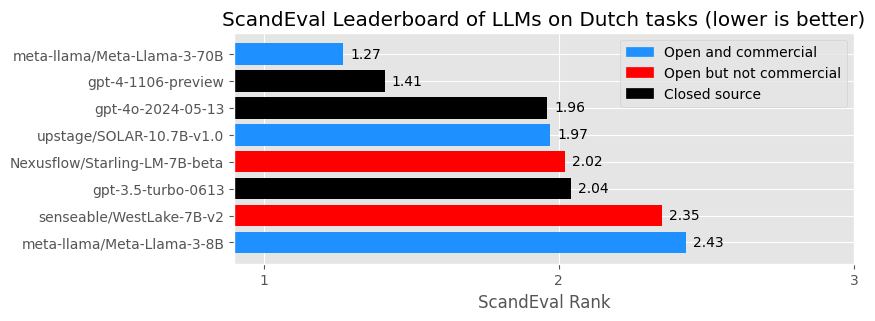

In [77]:
LANGUAGE = 'nl'
TOP_N = 15
MAX_VAL = 3
WIDTH = 8

leaderboard, score_column, title = language_mapping[LANGUAGE]
df = load_nlg_results_dataframe(language=leaderboard)
df = filter_models(df=df)
top_df = df.sort_values(by=score_column).head(TOP_N)[::-1]

length = 1 + len(top_df) // 4

colours = [get_colour(row=row) for _, row in top_df.iterrows()]
plt.figure(figsize=(WIDTH, length))
plot = plt.barh(y=top_df.index, width=top_df[score_column], color=colours)
plt.legend(
    handles=[
        mpatches.Patch(color='dodgerblue', label='Open and commercial'),
        mpatches.Patch(color='red', label='Open but not commercial'),
        mpatches.Patch(color='black', label='Closed source'),
    ],
)
plt.title(f'ScandEval Leaderboard of LLMs on {title} tasks (lower is better)')
plt.xticks(range(0, MAX_VAL + 1))
plt.xlim(0.9, MAX_VAL)
plt.xlabel('ScandEval Rank')
plt.bar_label(plot, padding=5, fmt="{:.2f}")
plt.savefig(f'/Users/dan/Downloads/{LANGUAGE}-llm-leaderboard.png', dpi=100, bbox_inches = "tight")
plt.show()